# 1. CROSS SAMPLES EXTRACTION

### INPUT

In [1]:
tf = '4h'; market = 'OANDA'
key = 'btc'; pair = 'usd'
slow_ma = 21; fast_ma = 7

### LIBRARIES

In [2]:
import pandas as pd
import pandas_ta as ta
import pickle

### MAIN

In [3]:
# Load correct mapping dictionary e.g. btc -> BTCUSD
map_path = f"../supp/maps_{pair}.pkl"
with open(map_path, 'rb') as pkl_file:
    mapp = pickle.load(pkl_file)

In [4]:
# Load historical prices for a specific market e.g. BINANCE
path = f"../data/{tf}/usd/{key}/"
in_filename = f"{path}/{mapp[key]}-{market}.csv"
df = pd.read_csv(in_filename).drop(columns = ['symbol']).set_index('datetime')
df.index = pd.to_datetime(df.index) # For plotting compatibility with mdates

In [5]:
# Adding indicators
df['sma_greater'] = df.ta.sma(fast_ma, append = True) > df.ta.sma(slow_ma, append = True)
df['bull_cross'] = (df['sma_greater'] & ~df['sma_greater'].shift(fill_value=False))
df['bear_cross'] = df['sma_greater'] & ~df['sma_greater'].shift(-1, fill_value=False)
df['bear_cross'] = df['bear_cross'].shift(fill_value=False) # needs to be adjusted, shift by 1 position to bottom

df.dropna(inplace = True)
df = df.iloc[1:] # drop first row which is an invalid bull cross
df['sma_var'] = df.apply(lambda row: (row['SMA_7'] - row['SMA_21'])/row['SMA_21']*100, axis = 1 )

In [6]:
df['target'] = 0

In [7]:
period = 7
df['rolling_std'] = df['close'].rolling(window=period).std()

In [8]:
# Extract Target as number of candles in bullish period (sma_var > 0)
df['target'] = 0
conta = 0; i_start = 0
bull_period = False

for i in range(len(df)):
    if df['bull_cross'].iloc[i] == True:
        bull_period = True
        i_start = i
    
    if bull_period == True:
        if df['sma_greater'].iloc[i] == True:
            conta += 1
        else:
            df.loc[df.index[i_start], 'target'] = conta
            bull_period = False
            conta = 0

In [9]:
# Choose size of cross samples
loc = 5 # candles before & after the cross (included)

# Extract Cross Samples
crosses = [df.iloc[i-loc:i+loc] for i in range(len(df)) if df['bull_cross'].iloc[i] == True]

# Find invalid samples with bear cross after bull cross
bear_inrange = list()
for idx, cross in enumerate(crosses):
    conta = 0
    for j in range(len(cross)):
        if (cross.bear_cross.iloc[j] == True) and (j > len(cross)/2):
            conta += 1
    if conta > 0:
        bear_inrange.append(idx)

# Remove samples with bearish cross AFTER a bullish cross
crosses = [cross for idx, cross in enumerate(crosses) if idx not in bear_inrange]

In [10]:
len(crosses)

135

In [11]:
crosses[21]

,open,high,low,close,volume,SMA_7,SMA_21,sma_greater,bull_cross,bear_cross,sma_var,target,rolling_std
datetime,,,,,,,,,,,,,
2020-08-27 23:00:00,11271.4,11363.9,11257.3,11353.5,8270.0,11352.714286,11446.742857,False,False,False,-0.821444,0,66.712054
2020-08-28 03:00:00,11353.5,11401.3,11338.8,11398.3,7714.0,11343.028571,11429.552381,False,False,False,-0.757018,0,50.444746
2020-08-28 07:00:00,11398.3,11454.7,11367.9,11404.8,8362.0,11347.685714,11414.109524,False,False,False,-0.581945,0,54.895277
2020-08-28 11:00:00,11404.8,11493.9,11404.0,11454.9,8984.0,11358.871429,11400.357143,False,False,False,-0.363898,0,68.146869
2020-08-28 15:00:00,11454.9,11552.2,11414.9,11520.8,11624.0,11382.457143,11392.538095,False,False,False,-0.088487,0,91.451970
2020-08-28 19:00:00,11520.8,11533.3,11469.5,11502.6,6022.0,11415.185714,11388.676190,True,True,False,0.232771,18,86.838268
2020-08-30 23:00:00,11502.6,11728.0,11502.6,11699.8,7044.0,11476.385714,11398.480952,True,False,False,0.683466,0,115.005934
2020-08-31 03:00:00,11699.8,11711.5,11650.1,11668.7,6994.0,11521.414286,11414.338095,True,False,False,0.938085,0,120.449899
2020-08-31 07:00:00,11668.7,11688.1,11579.1,11585.0,7401.0,11548.085714,11429.709524,True,False,False,1.035689,0,108.747053


# 2. FEATURE EXTRACTION

In [14]:
new_order = ['close', 'rolling_std', 'volume', 'SMA_7', 'SMA_21', 'sma_var', 'bull_cross', 'target']

In [29]:
crosses = [cross.reindex(new_order, axis=1) for cross in crosses]

In [32]:
def calc_pvar(base_val, val):
    return (val - base_val)/base_val

In [34]:
_ = crosses[1].copy()

In [37]:
# For each sample build a list of features
p_close = list(); p_volat = list()
p_slow = list(); p_fast = list()
r_sma = list()

target = list()

for cross in crosses:
    p_close.append(calc_pvar(cross.close.iloc[0], cross.close.iloc[-1]))
    p_volat.append(calc_pvar(cross.rolling_std.iloc[0], cross.rolling_std.iloc[-1]))
    p_slow.append(calc_pvar(cross.SMA_21.iloc[0], cross.SMA_21.iloc[-1]))
    p_fast.append(calc_pvar(cross.SMA_7.iloc[0], cross.SMA_7.iloc[-1]))
    r_sma.append(abs(cross.sma_var.iloc[-1] / cross.sma_var.iloc[0]))
    
    target.append(int(cross.target.iloc[loc]))

In [40]:
cols = ['p_close','p_volat','p_slow','p_fast','r_sma','target']
dm = pd.DataFrame(data = zip(p_close, p_volat, p_slow, p_fast, r_sma, target), columns = cols)

In [41]:
dm

,p_close,p_volat,p_slow,p_fast,r_sma,target
0,0.064660,1.113011,0.002716,0.050326,1.195096,30
1,0.069369,1.508648,0.005474,0.057274,1.585582,29
2,0.063471,0.726905,0.006617,0.046855,2.163102,39
3,-0.004705,2.432785,-0.009283,0.032968,0.300207,7
4,0.007486,-0.144527,-0.007851,0.022708,0.401851,25
...,...,...,...,...,...,...
130,0.013298,2.451038,-0.005065,0.013932,0.884147,10
131,0.057387,10.235887,0.010046,0.043105,6.080082,14
132,0.003928,3.063911,0.001923,0.012417,2.991425,10
133,0.020224,-0.552834,0.002355,0.022410,0.929849,39


In [47]:
from matplotlib import pyplot as plt

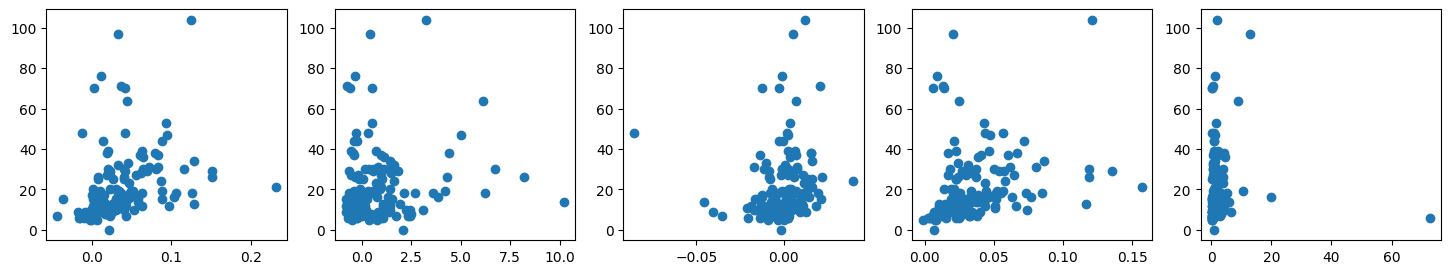

In [49]:
fig, axs = plt.subplots(ncols = 5, figsize = (18,3))
axs[0].scatter(dm.p_close, dm.target)
axs[1].scatter(dm.p_volat, dm.target)
axs[2].scatter(dm.p_slow, dm.target)
axs[3].scatter(dm.p_fast, dm.target)
axs[4].scatter(dm.r_sma, dm.target)

plt.show()

# 3. ML

In [60]:
import numpy as np

In [61]:
y = np.array(dm.target)

features = ['p_close','p_volat','p_slow','p_fast','r_sma']
X = np.array(dm[features])

In [110]:
# Split the data into training/testing sets
X_tr = X[:-10]
X_te = X[-10:]

# Split the targets into training/testing sets
y_tr = y[:-10]
y_te = y[-10:]

In [111]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score

In [112]:
model = ElasticNet(alpha = 1., l1_ratio = 0.5)

In [113]:
model.fit(X_tr, y_tr)

ElasticNet()

In [114]:
y_tr_p = model.predict(X_tr)

In [115]:
r2_score(y_tr_p, y_tr)

-67.15866293141485

In [ ]:
fig, ax = plt.subplots(ncols )